# Install

In [1]:
!pip install opencv-python==4.8.0.76
!pip install numpy==1.26.4

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
import zipfile
import os

# Correct path in Colab (NOT C:\Users...)
zip_path = "/content/archive (6).zip"
extract_path = "/content/data"

# Create data folder
os.makedirs(extract_path, exist_ok=True)

# Unzip dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted successfully!")

# Check folder structure
os.listdir(extract_path)

Dataset extracted successfully!


['Testing', 'Training']

In [4]:
import os
train_dir = "/content/data/Training"
test_dir  = "/content/data/Testing"
print("Train folders:", os.listdir(train_dir))
print("Test folders:", os.listdir(test_dir))

Train folders: ['pituitary', 'glioma', 'notumor', 'meningioma']
Test folders: ['pituitary', 'glioma', 'notumor', 'meningioma']


In [5]:
# image size (Standard for medical images)
IMG_SIZE = 224
# I standardized all MRI images to 224×224 resolution to ensure consistent
# input size for the CNN and stable training performance while preserving important medical features.

In [6]:
# Images loading
def load_images_opencv(data_dir):
    data = []
    labels = []
    class_names = sorted(os.listdir(data_dir))

    print("Classes:", class_names)

    for label, class_name in enumerate(class_names):
        class_path = os.path.join(data_dir, class_name)

        if not os.path.isdir(class_path):
            continue

        print(f"Loading images from: {class_name}")

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)

            # Skip hidden files
            if img_name.startswith('.'):
                continue

            try:
                # Read image
                img = cv2.imread(img_path)

                # VERY IMPORTANT: Check if image loaded
                if img is None:
                    print(f"Skipped unreadable image: {img_name}")
                    continue

                # Resize first
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

                # Convert to grayscale ONLY if image has 3 channels
                if len(img.shape) == 3:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                # Denoising (good for MRI images)
                img = cv2.GaussianBlur(img, (5, 5), 0)

                # Normalize to 0–1
                img = img.astype('float32') / 255.0

                data.append(img)
                labels.append(label)

            except Exception as e:
                print(f"Error processing {img_name}: {e}")

    print(f"\nTotal images successfully loaded: {len(data)}")
    return np.array(data), np.array(labels), class_names

In [7]:
print("Loading Training Data...")
X_train, y_train, class_names = load_images_opencv(train_dir)

print("\nLoading Testing Data...")
X_test, y_test, _ = load_images_opencv(test_dir)

print("\nTraining Shape:", X_train.shape)
print("Testing Shape:", X_test.shape)
print("Class Names:", class_names)

Loading Training Data...
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Loading images from: glioma
Loading images from: meningioma
Loading images from: notumor
Loading images from: pituitary

Total images successfully loaded: 5600

Loading Testing Data...
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Loading images from: glioma
Loading images from: meningioma
Loading images from: notumor
Loading images from: pituitary

Total images successfully loaded: 1600

Training Shape: (5600, 224, 224)
Testing Shape: (1600, 224, 224)
Class Names: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [8]:
import os

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        files = os.listdir(class_path)
        print(f"{class_name} -> Total files: {len(files)}")
        print("Sample files:", files[:5])
        print("------")

import os
os.listdir("/content/data")


pituitary -> Total files: 1400
Sample files: ['Tr-pi_1197.jpg', 'Tr-pi_1098.jpg', 'Tr-pi_896.jpg', 'Tr-pi_1289.jpg', 'Tr-pi_1249.jpg']
------
glioma -> Total files: 1400
Sample files: ['Tr-gl_401.jpg', 'Tr-gl_52.jpg', 'Tr-gl_721.jpg', 'Tr-gl_387.jpg', 'Tr-gl_1215.jpg']
------
notumor -> Total files: 1400
Sample files: ['Tr-no_92.jpg', 'Tr-no_1207.jpg', 'Tr-no_1235.jpg', 'Tr-no_877.jpg', 'Tr-no_180.jpg']
------
meningioma -> Total files: 1400
Sample files: ['Tr-me_385.jpg', 'Tr-me_449.jpg', 'Tr-me_990.jpg', 'Tr-aug-me_55.jpg', 'Tr-me_681.jpg']
------


['Testing', 'Training']

In [ ]:
# Takes a brain MRI image → Processes it → Predicts tumor type (glioma, meningioma, pituitary, or no tumor)
# MRI Image → OpenCV Preprocessing → CNN Model → Tumor Classification

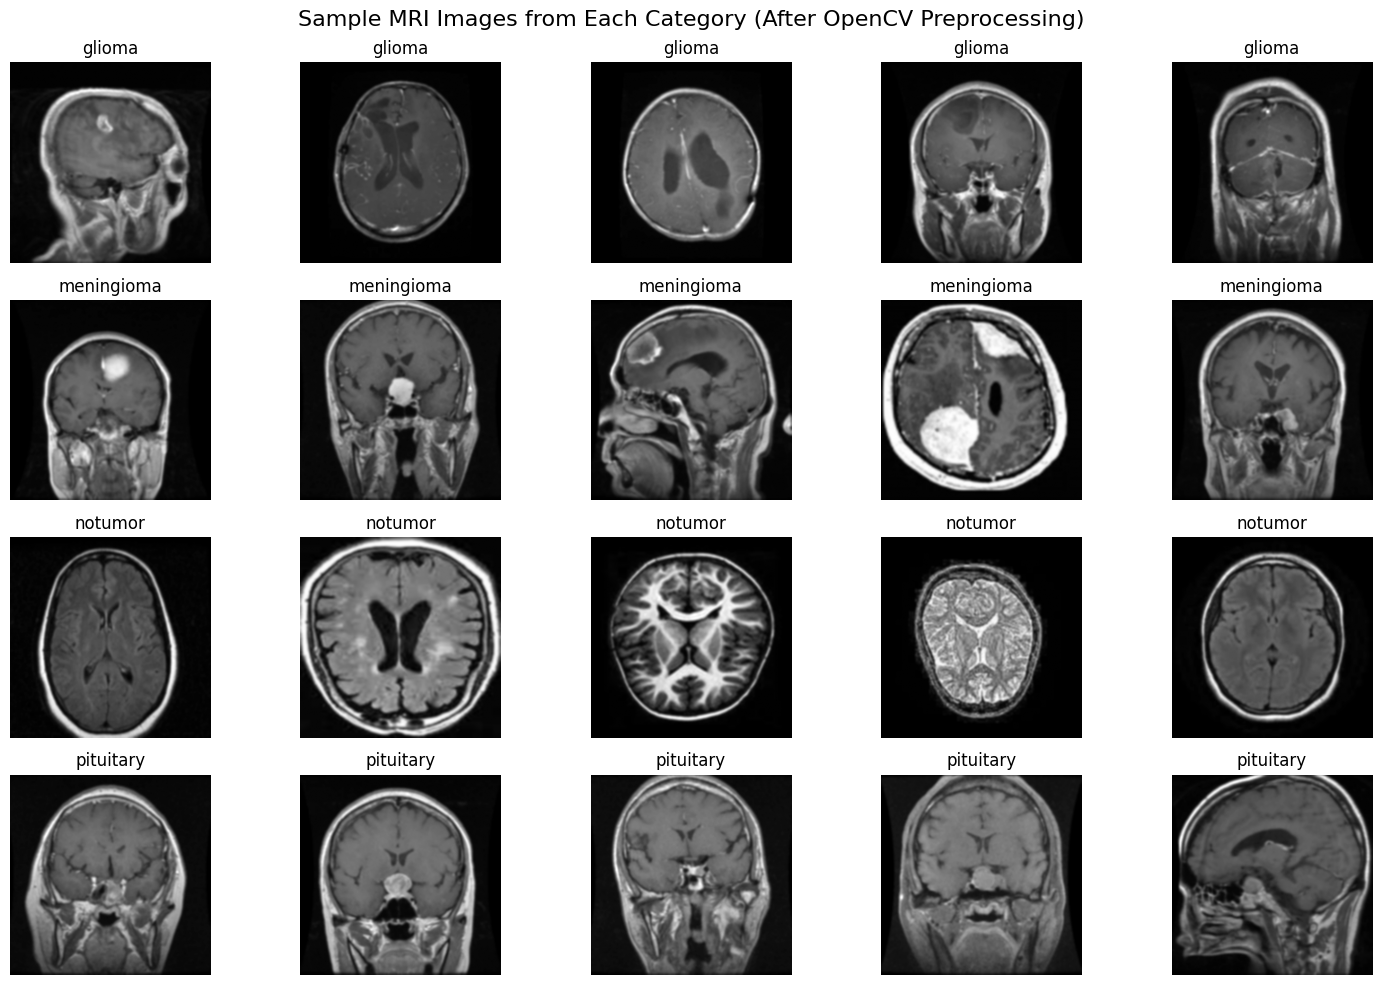

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def show_images_per_class(X, y, class_names, samples_per_class=5):
    plt.figure(figsize=(15, 10))

    for class_idx, class_name in enumerate(class_names):
        # Get indices of images belonging to this class
        class_indices = np.where(y == class_idx)[0]

        # Randomly select samples
        selected_indices = np.random.choice(class_indices, samples_per_class, replace=False)

        for i, idx in enumerate(selected_indices):
            plt.subplot(len(class_names), samples_per_class, class_idx * samples_per_class + i + 1)
            plt.imshow(X[idx], cmap='gray')
            plt.title(class_name)
            plt.axis('off')

    plt.suptitle("Sample MRI Images from Each Category (After OpenCV Preprocessing)", fontsize=16)
    plt.tight_layout()
    plt.show()

# Run EDA visualization
show_images_per_class(X_train, y_train, class_names, samples_per_class=5)

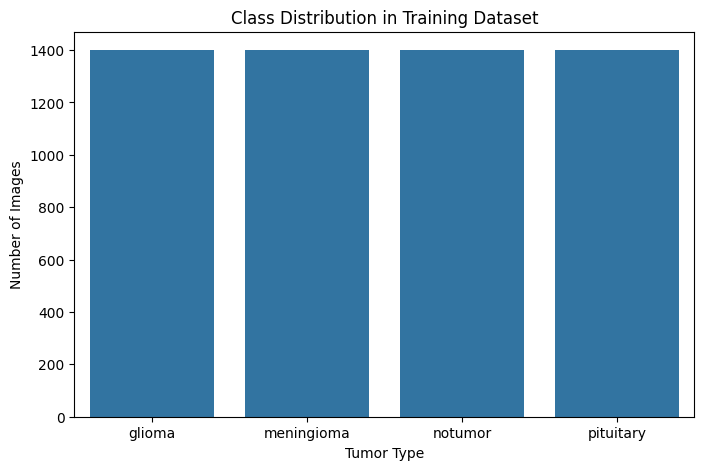

Class Distribution:
glioma: 1400 images
meningioma: 1400 images
notumor: 1400 images
pituitary: 1400 images


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Count images per class
unique, counts = np.unique(y_train, return_counts=True)

plt.figure(figsize=(8,5))
sns.barplot(x=[class_names[i] for i in unique], y=counts)
plt.title("Class Distribution in Training Dataset")
plt.xlabel("Tumor Type")
plt.ylabel("Number of Images")
plt.show()

print("Class Distribution:")
for i, count in zip(unique, counts):
    print(f"{class_names[i]}: {count} images")

In [11]:
print("Pixel Min Value:", X_train.min())
print("Pixel Max Value:", X_train.max())
print("Pixel Mean:", X_train.mean())
print("Pixel Std Dev:", X_train.std())

Pixel Min Value: 0.0
Pixel Max Value: 1.0
Pixel Mean: 0.18362905
Pixel Std Dev: 0.18893887


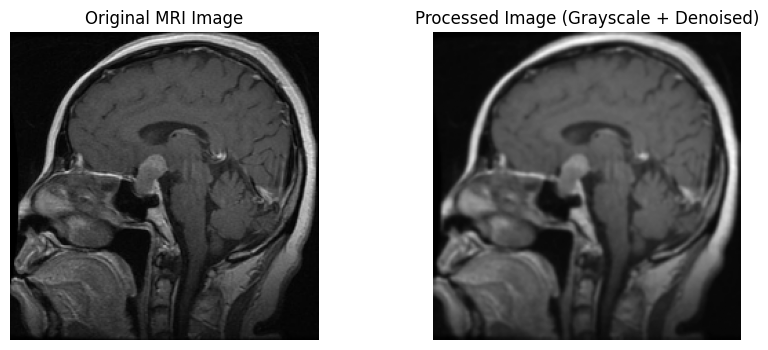

In [12]:
import cv2
import os
import random

# Pick a random class and image
random_class = random.choice(class_names)
sample_folder = os.path.join(train_dir, random_class)
sample_image_name = random.choice(os.listdir(sample_folder))
sample_image_path = os.path.join(sample_folder, sample_image_name)

# Original image
original = cv2.imread(sample_image_path)
original = cv2.resize(original, (224, 224))

# Processed image (same pipeline)
processed = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
processed = cv2.GaussianBlur(processed, (5,5), 0)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
plt.title("Original MRI Image")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(processed, cmap='gray')
plt.title("Processed Image (Grayscale + Denoised)")
plt.axis('off')

plt.show()

In [13]:
# Convert to 4D input for CNN
X_train = X_train.reshape(-1, 224, 224, 1)
X_test = X_test.reshape(-1, 224, 224, 1)

print("Train Shape:", X_train.shape)
print("Test Shape:", X_test.shape)

from tensorflow.keras.utils import to_categorical

# Convert integer labels (0,1,2,3) - one-hot vectors
y_train_cat = to_categorical(y_train, num_classes=4)
y_test_cat = to_categorical(y_test, num_classes=4)

print("Train Shape:", X_train.shape)
print("Test Shape:", X_test.shape)
print("Categorical Label Shape:", y_train_cat.shape)

Train Shape: (5600, 224, 224, 1)
Test Shape: (1600, 224, 224, 1)
Train Shape: (5600, 224, 224, 1)
Test Shape: (1600, 224, 224, 1)
Categorical Label Shape: (5600, 4)


In [ ]:
# CNN Model training

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# architecture
model = Sequential([

    # Block 1
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,1)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # Block 2
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # Block 3 (Deeper learning for medical features)
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # Block 4 (High-level tumor feature extraction)
    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # Flatten for Dense layers
    Flatten(),

    # Dense Layers (Decision making)
    Dense(256, activation='relu'),
    Dropout(0.5),  # Prevent overfitting

    Dense(128, activation='relu'),
    Dropout(0.3),

    # Output Layer (4 classes)
    Dense(4, activation='softmax')
])

# compile
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# trianing
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=15,
    batch_size=32,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     9,437,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,860,612 (37.62 MB)

 Trainable params: 9,859,652 (37.61 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 1155s 7s/step - accuracy: 0.5823 - loss: 1.4806 - val_accuracy: 0.2500 - val_loss: 5.1250
Epoch 2/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 1135s 6s/step - accuracy: 0.7277 - loss: 0.7265 - val_accuracy: 0.3675 - val_loss: 2.8256
Epoch 3/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 1187s 7s/step - accuracy: 0.7884 - loss: 0.5819 - val_accuracy: 0.6500 - val_loss: 0.9300
Epoch 4/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 1161s 7s/step - accuracy: 0.8406 - loss: 0.4365 - val_accuracy: 0.8087 - val_loss: 0.5884
Epoch 5/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 1163s 7s/step - accuracy: 0.8606 - loss: 0.3850 - val_accuracy: 0.8294 - val_loss: 0.5424
Epoch 6/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 1151s 7s/step - accuracy: 0.8984 - loss: 0.3260 - val_accuracy: 0.8206 - val_loss: 0.5669
Epoch 7/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 1166s 7s/step - accuracy: 0.8986 - loss: 0.2948 - val_accuracy: 0.8606 - val_loss: 0.4565
Epoch 8/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 1137s 6s/step - accuracy: 0.9120 - loss: 0.2524 - 

KeyboardInterrupt: 

In [15]:
model.save('/content/final_brain_tumor_model.h5')
print("Model safely saved!")

Model safely saved!


In [16]:
# Save in modern Keras format (recommended)
model.save('/content/final_brain_tumor_model.keras')

# Optional backup (HDF5 format)
model.save('/content/final_brain_tumor_model.h5')

print("Final model saved in both formats!")

Final model saved in both formats!


In [17]:
# Evaluate model on unseen test data
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat, verbose=1)

print("\n FINAL MODEL PERFORMANCE")
print("Test Accuracy:", round(test_accuracy * 100, 2), "%")
print("Test Loss:", round(test_loss, 4))

50/50 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.7922 - loss: 0.8689

 FINAL MODEL PERFORMANCE
Test Accuracy: 87.75 %
Test Loss: 0.4757


In [18]:
# generate predictions (needed for metrics)

# Predict probabilities
y_pred_probs = model.predict(X_test)

# Convert probabilities → class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels
y_true = np.argmax(y_test_cat, axis=1)

print("Prediction shape:", y_pred.shape)

50/50 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step
Prediction shape: (1600,)


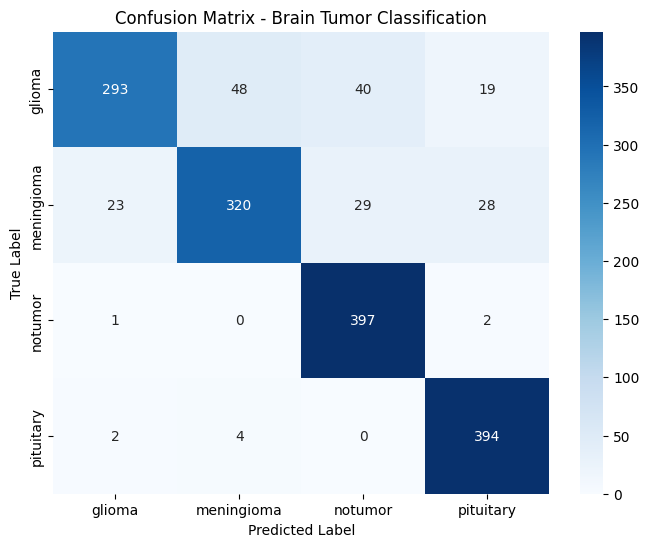

In [19]:
# Confusion metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.title("Confusion Matrix - Brain Tumor Classification")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



In [20]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=class_names)
print(" Classification Report:\n")
print(report)

 Classification Report:

              precision    recall  f1-score   support

      glioma       0.92      0.73      0.82       400
  meningioma       0.86      0.80      0.83       400
     notumor       0.85      0.99      0.92       400
   pituitary       0.89      0.98      0.93       400

    accuracy                           0.88      1600
   macro avg       0.88      0.88      0.87      1600
weighted avg       0.88      0.88      0.87      1600



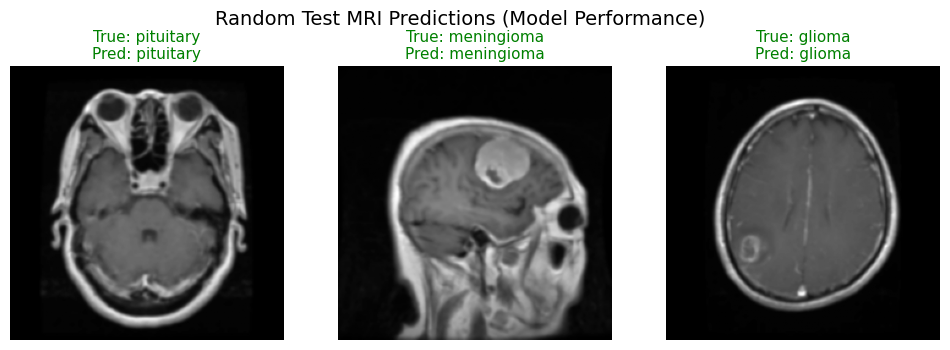

In [21]:
# Mode prediction
import random
import matplotlib.pyplot as plt

def show_random_predictions(X, y_true, y_pred, class_names, num_samples=3):
    plt.figure(figsize=(12,4))

    # Select random indices
    indices = random.sample(range(len(X)), num_samples)

    for i, idx in enumerate(indices):
        plt.subplot(1, num_samples, i+1)

        # Show image (grayscale)
        plt.imshow(X[idx].reshape(224,224), cmap='gray')

        true_label = class_names[y_true[idx]]
        pred_label = class_names[y_pred[idx]]

        plt.title(f"True: {true_label}\nPred: {pred_label}",
                  color='green' if true_label == pred_label else 'red',
                  fontsize=11)

        plt.axis('off')

    plt.suptitle("Random Test MRI Predictions (Model Performance)", fontsize=14)
    plt.show()

# Show 3 random predictions
show_random_predictions(X_test, y_true, y_pred, class_names, num_samples=3)